In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'drive/MyDrive/colab/final_nba_data.csv'
df = pd.read_csv(file_path, encoding='cp949', sep=',')

# Clean column names
df.columns = df.columns.str.strip()

# Example salary cap data
salary_cap_data = {
    'year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'salary_cap': [70000000, 94143000, 99093000, 101869000, 109140000, 109140000, 112414000, 112414000, 119025000, 119025000]
}
salary_cap_df = pd.DataFrame(salary_cap_data)

stats_columns = df.columns[8:]  # Assuming stats start from the 'Pos' column onwards
df = df.dropna(subset=stats_columns)

# Filter data for the desired years
df = df[(df['start'] > 2014) & (df['start'] < 2025)]

# Determine the salary cap based on the start year of each contract
df['salary'] = df.apply(lambda x: x['salary'] / salary_cap_df.set_index('year').loc[x['start'], 'salary_cap'], axis=1)

contract_data = []

In [ ]:
for i in range(1, len(df)):
    current_contract = df.iloc[i]
    past_contract = df.iloc[i - 1]

    if current_contract['name'] == past_contract['name']:
        debut_diff = current_contract['start'] - current_contract['debut']  # 경력 계산
        past_stats = past_contract[stats_columns]  # 이전 계약의 통계 데이터 가져오기
        current_salary_to_cap = current_contract['salary'] / salary_cap_df.set_index('year').loc[current_contract['start'], 'salary_cap']
        contract_data.append({
            'name': current_contract['name'],
            'debut_diff': debut_diff,  # 경력 추가
            'past_salary': past_contract['salary'],
            'current_salary': current_contract['salary'],
            'past_stats': past_stats  # 이전 계약의 통계 데이터 추가
        })

# Create a dataframe from contract data
contract_df = pd.DataFrame(contract_data)

In [ ]:
# Split past_stats into individual columns
for stat in stats_columns:
    contract_df[f'past_{stat}'] = contract_df['past_stats'].apply(lambda x: x[stats_columns.get_loc(stat)])

# Drop unnecessary columns from contract_df
X = contract_df.drop(columns=['name', 'current_salary', 'past_stats']).values
y = contract_df['current_salary'].values

# Split data
X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(
    X, y, range(len(y)), test_size=0.2, random_state=42)

# Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [ ]:
# Define the PlayerDataset class
class PlayerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Create Dataset and DataLoader
train_dataset = PlayerDataset(X_train_tensor, y_train_tensor)
test_dataset = PlayerDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, loss function, and optimizer
model = SimpleNN(X_train_scaled.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Define training function
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (features, targets) in enumerate(train_loader, 1):
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % 10 == 0:  # Print every 10 batches
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {running_loss/len(train_loader):.4f}')

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=100)

# Define evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for features, targets in test_loader:
            outputs = model(features)
            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(targets.squeeze().tolist())
    return predictions, actuals

# Evaluate the model
predictions, actuals = evaluate_model(model, test_loader)

Epoch 1/100, Batch 10/81, Loss: 0.0063
Epoch 1/100, Batch 20/81, Loss: 0.0005
Epoch 1/100, Batch 30/81, Loss: 0.0013
Epoch 1/100, Batch 40/81, Loss: 0.0009
Epoch 1/100, Batch 50/81, Loss: 0.0035
Epoch 1/100, Batch 60/81, Loss: 0.0006
Epoch 1/100, Batch 70/81, Loss: 0.0017
Epoch 1/100, Batch 80/81, Loss: 0.0011
Epoch 1/100, Average Loss: 0.0027
Epoch 2/100, Batch 10/81, Loss: 0.0014
Epoch 2/100, Batch 20/81, Loss: 0.0015
Epoch 2/100, Batch 30/81, Loss: 0.0002
Epoch 2/100, Batch 40/81, Loss: 0.0014
Epoch 2/100, Batch 50/81, Loss: 0.0002
Epoch 2/100, Batch 60/81, Loss: 0.0004
Epoch 2/100, Batch 70/81, Loss: 0.0028
Epoch 2/100, Batch 80/81, Loss: 0.0026
Epoch 2/100, Average Loss: 0.0011
Epoch 3/100, Batch 10/81, Loss: 0.0012
Epoch 3/100, Batch 20/81, Loss: 0.0018
Epoch 3/100, Batch 30/81, Loss: 0.0004
Epoch 3/100, Batch 40/81, Loss: 0.0014
Epoch 3/100, Batch 50/81, Loss: 0.0003
Epoch 3/100, Batch 60/81, Loss: 0.0010
Epoch 3/100, Batch 70/81, Loss: 0.0013
Epoch 3/100, Batch 80/81, Loss: 0.0

Top 10 Overvalued Players:
                   name  predicted_salary  actual_salary     error
1335  Russell Westbrook          0.106212       0.303056  0.196844
374       DeMar DeRozan          0.085114       0.242852  0.157738
173         Brook Lopez          0.110099       0.201638  0.091539
602         Ian Mahinmi          0.091761       0.169954  0.078193
567      Gordon Hayward          0.196691       0.274876  0.078185
1603       Zach Collins         -0.008194       0.065383  0.073577
44       Andre Iguodala          0.071667       0.137438  0.065771
906        Kelly Olynyk          0.045359       0.110271  0.064912
925        Kevin Durant          0.369875       0.431929  0.062054
736          Jeff Green          0.008889       0.067213  0.058323

Top 10 Undervalued Players:
                   name  predicted_salary  actual_salary     error
1037         Marc Gasol          0.208604       0.024087 -0.184517
982   LaMarcus Aldridge          0.190035       0.023500 -0.166535
162   

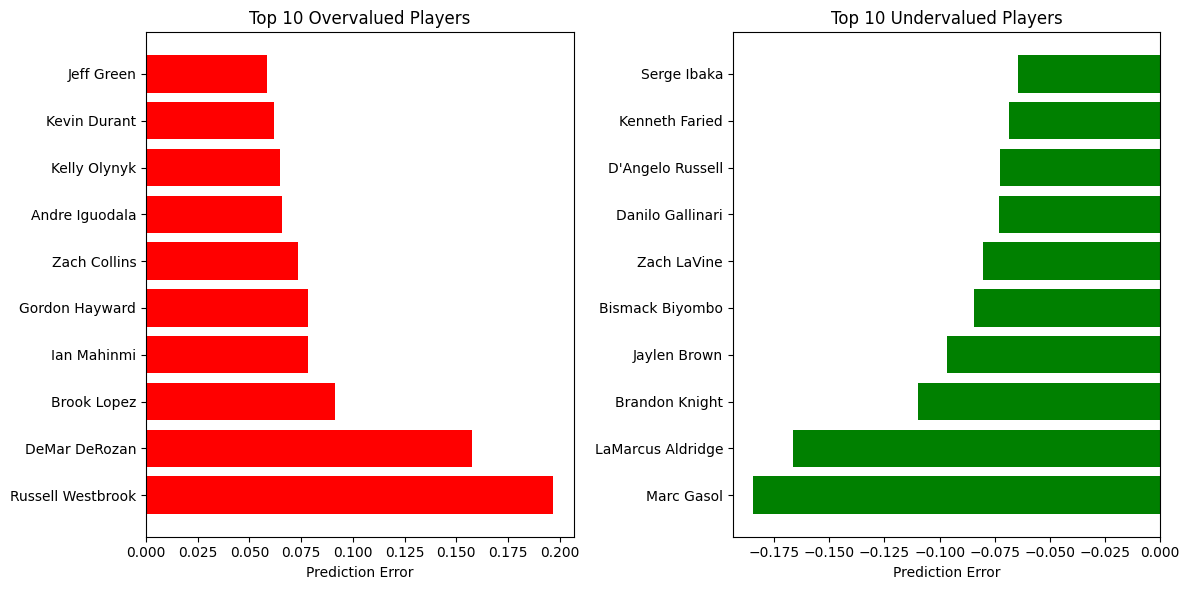

In [ ]:
# Add prediction results to the test dataframe
test_contract_df = contract_df.iloc[test_index].copy()
test_contract_df['error'] = np.array(actuals) - np.array(predictions)
test_contract_df['predicted_salary'] = predictions
test_contract_df['actual_salary'] = actuals

# Sort by error to find top overvalued and undervalued players
overvalued = test_contract_df.sort_values(by='error', ascending=False).head(10)
undervalued = test_contract_df.sort_values(by='error').head(10)

print("Top 10 Overvalued Players:")
print(overvalued[['name', 'predicted_salary', 'actual_salary', 'error']])

print("\nTop 10 Undervalued Players:")
print(undervalued[['name', 'predicted_salary', 'actual_salary', 'error']])

# Visualize the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(overvalued['name'], overvalued['error'], color='red')
plt.xlabel('Prediction Error')
plt.title('Top 10 Overvalued Players')

plt.subplot(1, 2, 2)
plt.barh(undervalued['name'], undervalued['error'], color='green')
plt.xlabel('Prediction Error')
plt.title('Top 10 Undervalued Players')

plt.tight_layout()
plt.show()

Feature Importances:
past_salary: 22.07%
debut_diff: 4.44%
past_G: 3.86%
past_BLK: 3.63%
past_STL: 3.53%
past_FGA: 3.43%
past_FTA: 3.41%
past_TOV: 3.41%
past_3P: 3.32%
past_ORB: 3.24%
past_AST: 3.17%
past_PF: 3.08%
past_2P: 3.04%
past_3PA: 3.03%
past_3P%: 2.94%
past_MP: 2.91%
past_GS: 2.89%
past_FT: 2.89%
past_DRB: 2.70%
past_2PA: 2.57%
past_eFG%: 2.54%
past_FG: 2.46%
past_2P%: 2.42%
past_FG%: 2.28%
past_PTS: 2.27%
past_FT%: 2.24%
past_TRB: 2.24%


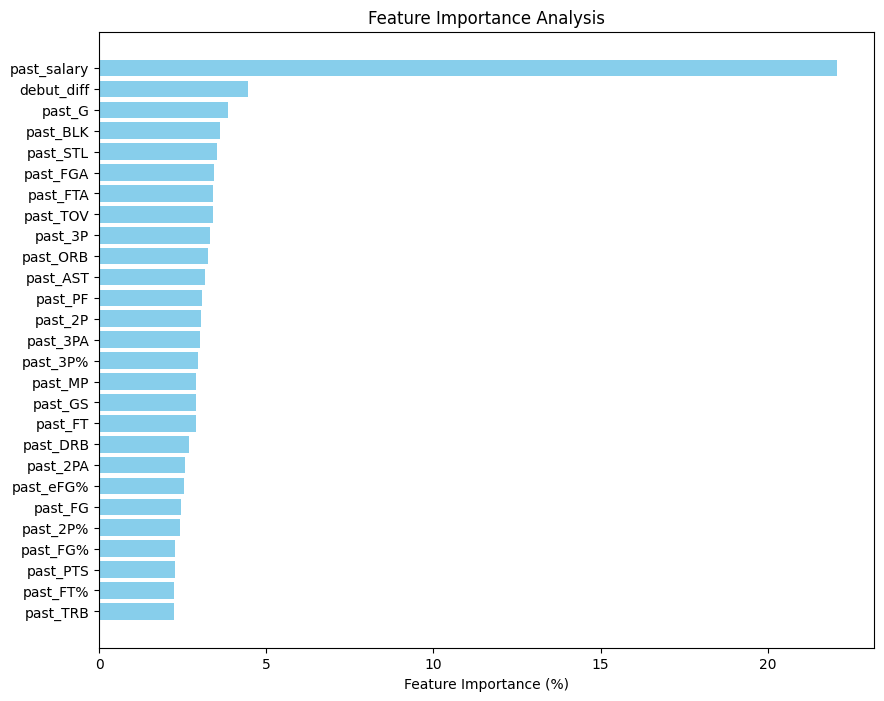

R2 Score: 0.7134


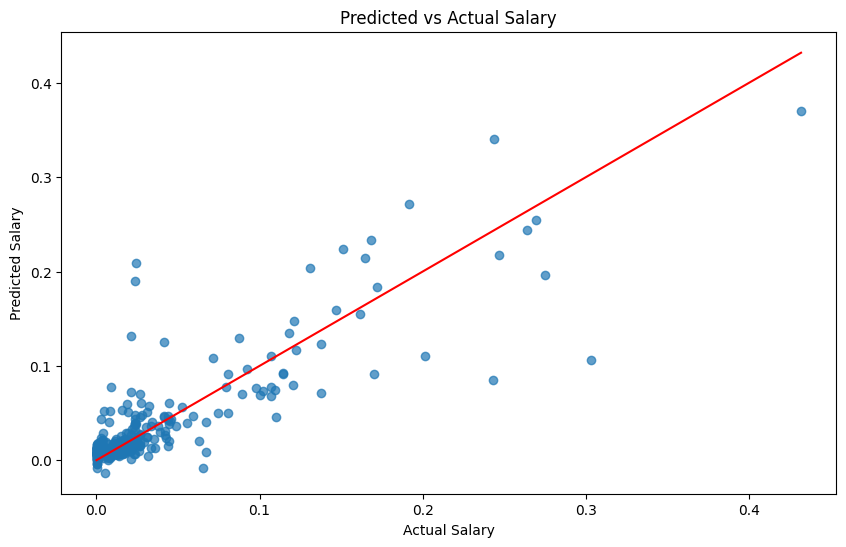

In [ ]:
# Feature importance analysis function
def feature_importance(model, X):
    model.eval()
    baseline_pred = model(X).detach().numpy()
    feature_importances = []
    for i in range(X.shape[1]):
        X_permuted = X.clone()
        X_permuted[:, i] = torch.randn(X_permuted[:, i].shape)
        permuted_pred = model(X_permuted).detach().numpy()
        importance = np.mean(np.abs(baseline_pred - permuted_pred))
        feature_importances.append(importance)
    return np.array(feature_importances).reshape(-1, 1)


# Calculate feature importance
X_all_scaled = scaler.transform(X)
X_all_tensor = torch.tensor(X_all_scaled, dtype=torch.float32)
feature_importances = feature_importance(model, X_all_tensor)

# Normalize to percentages
feature_importances_percentage = (feature_importances / feature_importances.sum()) * 100

# Output feature importance
features = contract_df.drop(columns=['current_salary', 'name', 'past_stats']).columns.tolist()
importance_df = pd.DataFrame(feature_importances_percentage, index=features, columns=['Importance'])

# Sort by importance and visualize
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print the feature importances as percentages
print("Feature Importances:")
for feature, importance in importance_df.itertuples():
    print(f"{feature}: {importance:.2f}%")

# Visualize the results
plt.figure(figsize=(10, 8))
plt.barh(importance_df.index, importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance (%)')
plt.title('Feature Importance Analysis')
plt.gca().invert_yaxis()
plt.show()

# Calculate R2 score
r2 = r2_score(actuals, predictions)
print(f'R2 Score: {r2:.4f}')

# Visualize predicted vs actual salaries
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.7)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Predicted vs Actual Salary')
plt.show()

past salary 제거 한 버전
(past salary를 학습에서 제외하니 R2 지표가 확연히 낮아짐)

Epoch 1/100, Batch 10/81, Loss: 0.0054
Epoch 1/100, Batch 20/81, Loss: 0.0030
Epoch 1/100, Batch 30/81, Loss: 0.0023
Epoch 1/100, Batch 40/81, Loss: 0.0055
Epoch 1/100, Batch 50/81, Loss: 0.0018
Epoch 1/100, Batch 60/81, Loss: 0.0041
Epoch 1/100, Batch 70/81, Loss: 0.0029
Epoch 1/100, Batch 80/81, Loss: 0.0047
Epoch 1/100, Average Loss: 0.0043
Epoch 2/100, Batch 10/81, Loss: 0.0007
Epoch 2/100, Batch 20/81, Loss: 0.0014
Epoch 2/100, Batch 30/81, Loss: 0.0011
Epoch 2/100, Batch 40/81, Loss: 0.0007
Epoch 2/100, Batch 50/81, Loss: 0.0016
Epoch 2/100, Batch 60/81, Loss: 0.0025
Epoch 2/100, Batch 70/81, Loss: 0.0045
Epoch 2/100, Batch 80/81, Loss: 0.0066
Epoch 2/100, Average Loss: 0.0024
Epoch 3/100, Batch 10/81, Loss: 0.0014
Epoch 3/100, Batch 20/81, Loss: 0.0016
Epoch 3/100, Batch 30/81, Loss: 0.0019
Epoch 3/100, Batch 40/81, Loss: 0.0015
Epoch 3/100, Batch 50/81, Loss: 0.0013
Epoch 3/100, Batch 60/81, Loss: 0.0003
Epoch 3/100, Batch 70/81, Loss: 0.0007
Epoch 3/100, Batch 80/81, Loss: 0.0

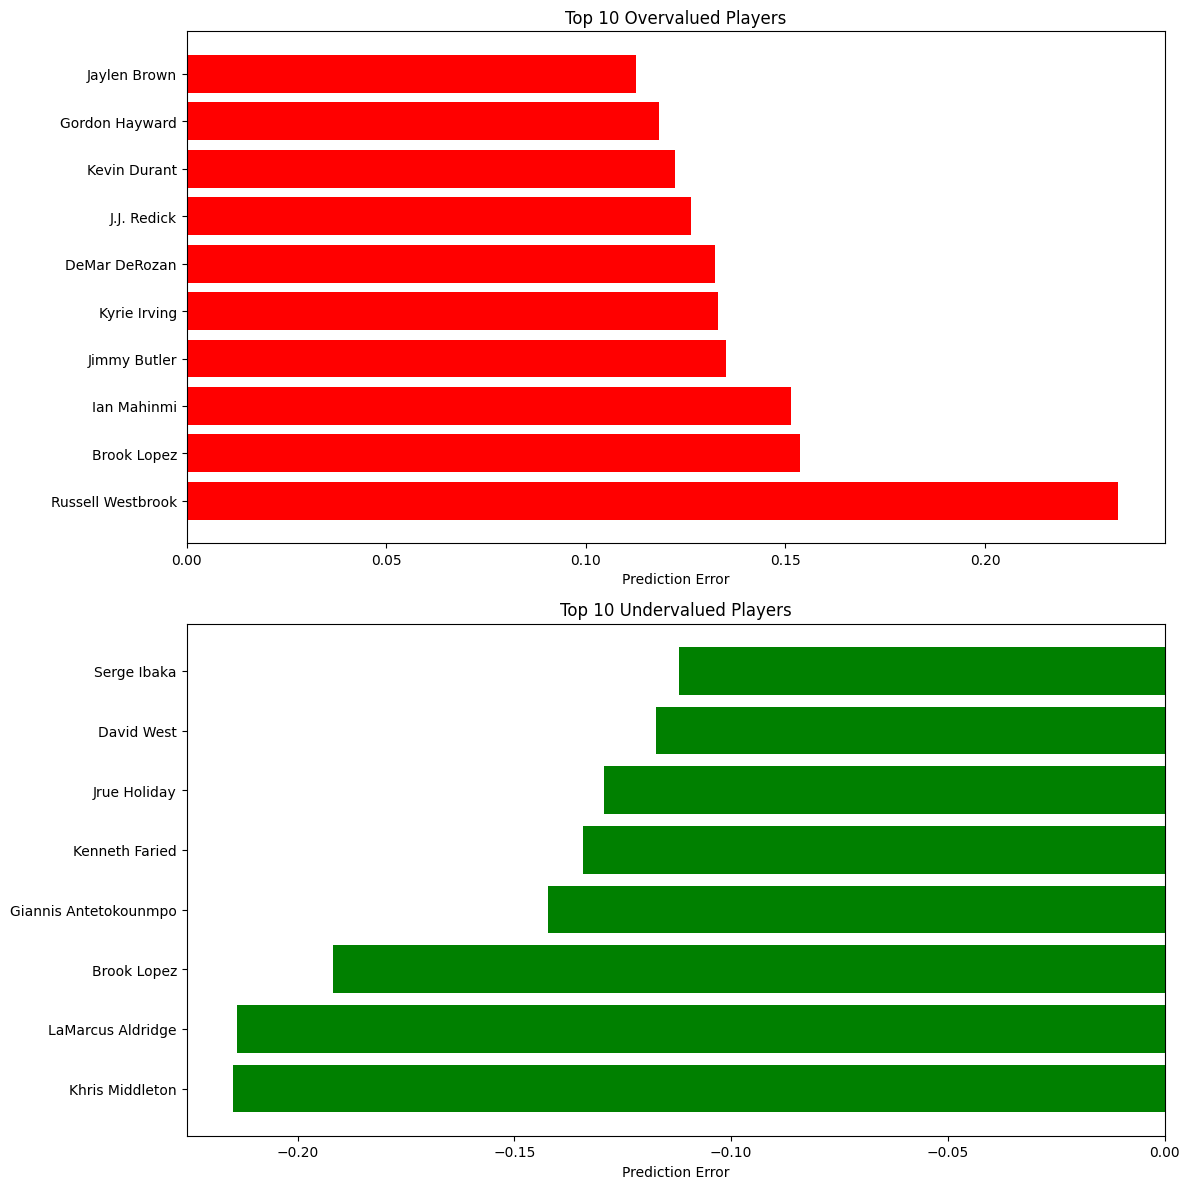

R2 Score: 0.2648


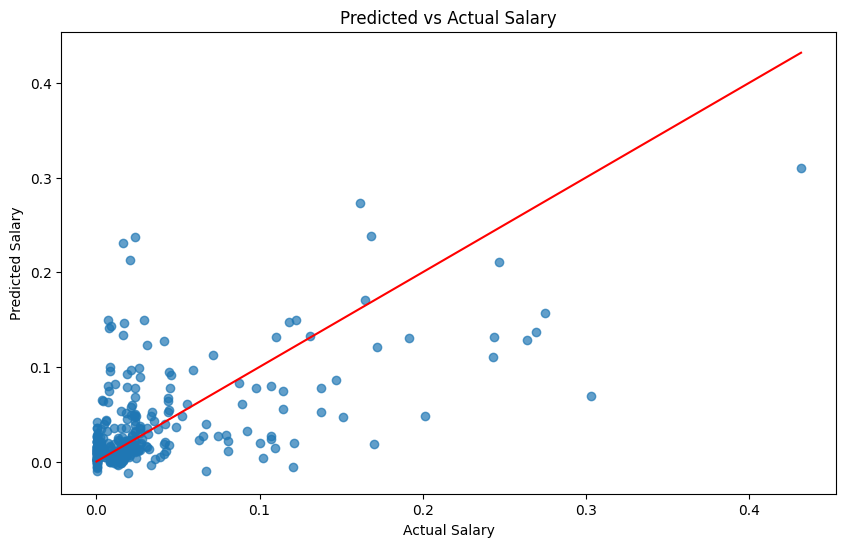

Feature Importances:
debut_diff: 7.35%
past_PF: 5.05%
past_ORB: 4.89%
past_GS: 4.80%
past_AST: 4.36%
past_STL: 4.35%
past_MP: 4.25%
past_PTS: 4.20%
past_G: 4.02%
past_FT: 3.94%
past_3PA: 3.74%
past_BLK: 3.73%
past_2PA: 3.72%
past_FG: 3.70%
past_3P%: 3.64%
past_TOV: 3.58%
past_FTA: 3.56%
past_3P: 3.34%
past_TRB: 3.33%
past_2P%: 3.08%
past_eFG%: 3.06%
past_DRB: 3.05%
past_FGA: 3.04%
past_FG%: 2.88%
past_2P: 2.72%
past_FT%: 2.61%


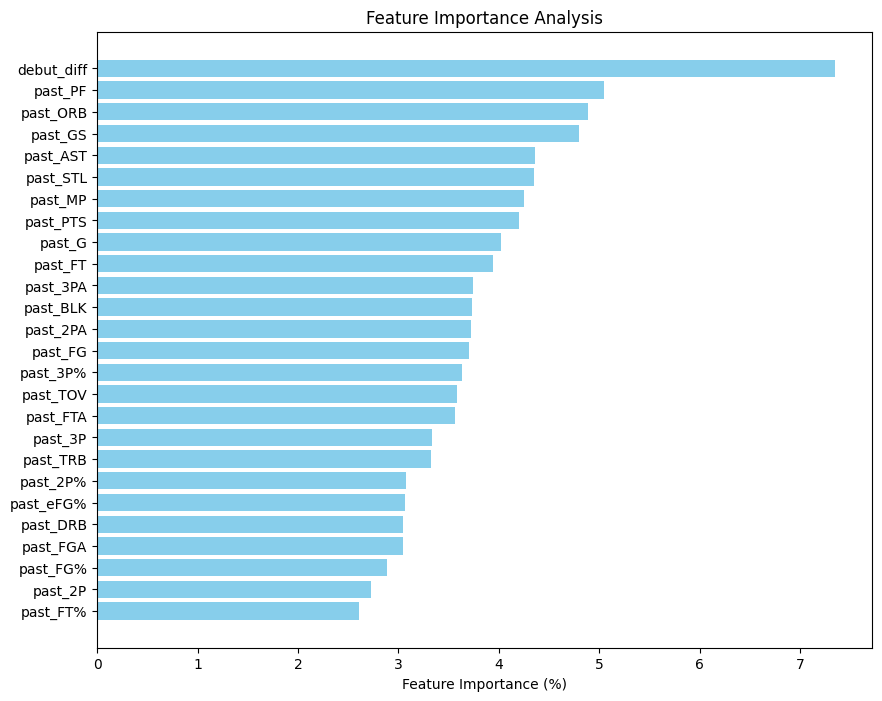

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'drive/MyDrive/colab/final_nba_data.csv'
df = pd.read_csv(file_path, encoding='cp949', sep=',')

# Clean column names
df.columns = df.columns.str.strip()

# Example salary cap data
salary_cap_data = {
    'year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'salary_cap': [70000000, 94143000, 99093000, 101869000, 109140000, 109140000, 112414000, 112414000, 119025000, 119025000]
}
salary_cap_df = pd.DataFrame(salary_cap_data)

stats_columns = df.columns[8:]  # Assuming stats start from the 'Pos' column onwards
df = df.dropna(subset=stats_columns)

# Filter data for the desired years
df = df[(df['start'] > 2014) & (df['start'] < 2025)]

# Determine the salary cap based on the start year of each contract
df['salary'] = df.apply(lambda x: x['salary'] / salary_cap_df.set_index('year').loc[x['start'], 'salary_cap'], axis=1)

contract_data = []

for i in range(1, len(df)):
    current_contract = df.iloc[i]
    past_contract = df.iloc[i - 1]

    if current_contract['name'] == past_contract['name']:
        debut_diff = current_contract['start'] - current_contract['debut']  # 경력 계산
        past_stats = past_contract[stats_columns]  # 이전 계약의 통계 데이터 가져오기
        contract_data.append({
            'name': current_contract['name'],
            'debut_diff': debut_diff,  # 경력 추가
            'current_salary': current_contract['salary'],
            'past_stats': past_stats  # 이전 계약의 통계 데이터 추가
        })

# Create a dataframe from contract data
contract_df = pd.DataFrame(contract_data)

# Split past_stats into individual columns
for stat in stats_columns:
    contract_df[f'past_{stat}'] = contract_df['past_stats'].apply(lambda x: x[stats_columns.get_loc(stat)])

# Drop the combined past_stats column
contract_df = contract_df.drop(columns=['past_stats'])

# Exclude past_salary from the features
X = contract_df.drop(columns=['current_salary', 'name']).values
y = contract_df['current_salary'].values

# Split data
X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(X, y, range(len(y)), test_size=0.2, random_state=42)

# Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define the PlayerDataset class
class PlayerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Create Dataset and DataLoader
train_dataset = PlayerDataset(X_train_tensor, y_train_tensor)
test_dataset = PlayerDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, loss function, and optimizer
model = SimpleNN(X_train_scaled.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define training function
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (features, targets) in enumerate(train_loader, 1):
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % 10 == 0:  # Print every 10 batches
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {running_loss/len(train_loader):.4f}')

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=100)

# Define evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for features, targets in test_loader:
            outputs = model(features)
            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(targets.squeeze().tolist())
    return predictions, actuals

# Evaluate the model
predictions, actuals = evaluate_model(model, test_loader)

# Add prediction results to the test dataframe
test_contract_df = contract_df.iloc[test_index].copy()
test_contract_df['error'] = np.array(actuals) - np.array(predictions)
test_contract_df['predicted_salary'] = predictions
test_contract_df['actual_salary'] = actuals

# Ensure 'name' column is included
test_contract_df['name'] = contract_df.iloc[test_index]['name'].values

# Sort by error to find top overvalued and undervalued players
overvalued = test_contract_df.sort_values(by='error', ascending=False).head(10)
undervalued = test_contract_df.sort_values(by='error').head(10)

# Create tables for overvalued and undervalued players
overvalued_table = overvalued[['name', 'predicted_salary', 'current_salary']]
undervalued_table = undervalued[['name', 'predicted_salary', 'current_salary']]

# Display the tables
print("Top 10 Overvalued Players:")
print(overvalued_table)

print("\nTop 10 Undervalued Players:")
print(undervalued_table)

# Enhanced Visualization for Overvalued and Undervalued Players
def plot_valuation(overvalued, undervalued):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

    # Plot overvalued players
    axes[0].barh(overvalued['name'], overvalued['error'], color='red')
    axes[0].set_xlabel('Prediction Error')
    axes[0].set_title('Top 10 Overvalued Players')

    # Plot undervalued players
    axes[1].barh(undervalued['name'], undervalued['error'], color='green')
    axes[1].set_xlabel('Prediction Error')
    axes[1].set_title('Top 10 Undervalued Players')

    plt.tight_layout()
    plt.show()

# Plot the valuation
plot_valuation(overvalued, undervalued)

# Calculate R2 score
r2 = r2_score(actuals, predictions)
print(f'R2 Score: {r2:.4f}')

# Visualize predicted vs actual salaries
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.7)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Predicted vs Actual Salary')
plt.show()

# Feature importance analysis function
def feature_importance(model, X):
    model.eval()
    baseline_pred = model(X).detach().numpy()
    feature_importances = []
    for i in range(X.shape[1]):
        X_permuted = X.clone()
        X_permuted[:, i] = torch.randn(X_permuted[:, i].shape)
        permuted_pred = model(X_permuted).detach().numpy()
        importance = np.mean(np.abs(baseline_pred - permuted_pred))
        feature_importances.append(importance)
    return np.array(feature_importances).reshape(-1, 1)

# Calculate feature importance
X_all_scaled = scaler.transform(X)
X_all_tensor = torch.tensor(X_all_scaled, dtype=torch.float32)
feature_importances = feature_importance(model, X_all_tensor)

# Normalize to percentages
feature_importances_percentage = (feature_importances / feature_importances.sum()) * 100

# Output feature importance
features = contract_df.drop(columns=['current_salary', 'name']).columns.tolist()
importance_df = pd.DataFrame(feature_importances_percentage, index=features, columns=['Importance'])

# Sort by importance and visualize
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print the feature importances as percentages
print("Feature Importances:")
for feature, importance in importance_df.itertuples():
    print(f"{feature}: {importance:.2f}%")

# Visualize the results
plt.figure(figsize=(10, 8))
plt.barh(importance_df.index, importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance (%)')
plt.title('Feature Importance Analysis')
plt.gca().invert_yaxis()
plt.show()


단기 계약같이 너무 낮은 금액을 받는 경우를 제외한 경우

(최대 2계약전 데이터를 볼 경우) 2개이상 없다면 제외